## Text Flappy Bird
*Romain Mondelice*

The goal of this assignment is to apply reinforcement learning methods to a
simple game called Text Flappy Bird (TFB). The game is a variation to the
well know Flappy Bird in which the player is made with a simple unit-element
character

## General imports

In [ ]:
import os, sys
import gymnasium as gym
import time

import numpy as np
from collections import defaultdict
from tqdm import tqdm
import pickle
import random

import matplotlib.pyplot as plt
import seaborn as sns

import text_flappy_bird_gym

## Preprocess env

In [ ]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

In [ ]:
total_reward = 0
while True:
        # Select next action
        action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)
        total_reward += reward

        # Render the game
        os.system("clear")
        sys.stdout.write(env.render())
        time.sleep(0.2) # FPS

        # If player is dead break
        if done:
            break

In [ ]:
print(total_reward)
env.close()

## Monte Carlo based agent

In [ ]:
class OffPolicyMonteCarloAgent:
    def __init__(self, env, gamma=0.9, epsilon=0.1):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(self.zero_action_value)
        self.C = defaultdict(self.zero_action_value)
        self.target_policy = defaultdict(int)

    def zero_action_value(self):
        return np.zeros(self.env.action_space.n)
        
    def generate_episode(self, policy):
        episode = []
        state = self.env.reset()
        done = False
        while not done:
            # Convert state to a string representation.
            str_state = str(state)

            if str_state in policy:
                action_probs = policy[str_state]
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            else:
                # Fallback if the state is not in the policy, use uniform random selection
                action = self.env.action_space.sample()

            next_state, reward, done, _, info = self.env.step(action)
            episode.append((str_state, action, reward))
            state = next_state
        return episode
    
    def get_probs(self, Q_s, epsilon, nA):
        """Obtains the policy for a given state"""
        policy_s = np.ones(nA) * epsilon / nA
        best_a = np.argmax(Q_s)
        policy_s[best_a] = 1 - epsilon + (epsilon / nA)
        return policy_s
    
    def update_Q(self, episode):
        G = 0.0
        W = 1.0
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.gamma * G + reward
            self.C[state][action] += W
            self.Q[state][action] += (W / self.C[state][action]) * (G - self.Q[state][action])
            self.target_policy[state] = np.argmax(self.Q[state])
            
            if action != self.target_policy[state]:
                break
            W = W * 1./self.get_probs(self.Q[state], self.epsilon, self.env.action_space.n)[action]
            
    def train(self, num_episodes):
        for i_episode in range(1, num_episodes + 1):
            episode = self.generate_episode(policy=self.create_behavior_policy(self.Q))
            self.update_Q(episode)
    
    def create_behavior_policy(self, Q):
        """Creates a behavior policy using ε-greedy approach based on Q."""
        behavior_policy = {}
        for state, actions in Q.items():
            behavior_policy[state] = self.get_probs(actions, self.epsilon, self.env.action_space.n)
        return behavior_policy

In [ ]:
def train_monte_carlo_agent(env_str, episodes=1000, gamma=0.9, epsilon=0.1):
    env = gym.make(env_str, height=15, width=20, pipe_gap=4)
    agent = OffPolicyMonteCarloAgent(env, gamma=gamma, epsilon=epsilon)
    
    episode_rewards = []  # List to store total reward from each episode

    for _ in tqdm(range(episodes), desc="Training process"):
        # Create the behavior policy from current Q
        behavior_policy = agent.create_behavior_policy(agent.Q)
        # Generate an episode using the behavior policy
        episode = agent.generate_episode(behavior_policy)
        # Update Q-values based on the episode
        agent.update_Q(episode)
        
        # Calculate total reward for the episode and store it
        total_reward = sum([reward for (_, _, reward) in episode])
        episode_rewards.append(total_reward)
    
    print("Training completed.")
    return agent, episode_rewards

In [ ]:
def test_agent(agent, episodes=100, reward_threshold=10000):
    total_rewards = 0
    episode_scores = []  # To store the score of each episode

    for episode_num in tqdm(range(1, episodes + 1), desc="Testing episodes"):
        state = agent.env.reset()
        done = False
        episode_reward = 0

        while not done:
            # Convert state to a string representation for consistency.
            str_state = str(state)
            
            # Use the target_policy for action selection if this state has been seen.
            # Otherwise, select a random action.
            if str_state in agent.target_policy:
                action = agent.target_policy[str_state]
            else:
                action = agent.env.action_space.sample()

            state, reward, done, _, info = agent.env.step(action)
            episode_reward += reward

            # Check if the reward threshold for this episode has been exceeded
            if episode_reward > reward_threshold:
                break

        # Episode is done or threshold exceeded, append its total reward to episode_scores
        episode_scores.append(episode_reward)
        total_rewards += episode_reward
    
    avg_reward = total_rewards / episodes
    print("Total reward across all episodes: ", total_rewards)
    print(f"Average Reward over {episodes} episodes: {avg_reward}")
    return avg_reward

### Text Flappy Bird Screen env

#### Training

In [ ]:
trained_agent, episode_rewards = train_monte_carlo_agent('TextFlappyBird-screen-v0', episodes=5000)

#### Testing

In [ ]:
# Test the trained Monte Carlo agent
test_agent(trained_agent)

### Text Flappy Bird env

#### Training

In [ ]:
trained_agent, episode_rewards = train_monte_carlo_agent('TextFlappyBird-v0', episodes=20000)

#### Testing

Here I have set the reward treshold to 10000 in my function so the maximum reward that one episode can reach is 10000 and the maximum average reward over 100 episodes that we can reach is 10000 should not exceed 10000.

If we go in this case that mean that the model learn extremly well and can go and have a very high score. We need to stop the test other wise it will take infinite amount of time.

In [ ]:
test_agent(trained_agent)

### Effect of the two different environments

As we can saw from the first implementation, with the "screen" environment the Monte Carlo model is not able to converge at all to a correct policy.
Also the computation time way more longer.

However with the classical env that returns the distance of the player from the center of the closest upcoming pipe gap we manage to converge quite quickly and also to have a very optimal policy.

In global, for this agent the classical env return more exploitable feature in order to converge.

Therefor all the following analysis will be conducted on the classical environment, as this is the more pertinent for the Monte Carlo based agent.

### Sensitivity to parameters

In [ ]:
gammas = [0.8, 0.85, 0.9, 0.95, 1.0]  # Gamma values
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]  # Epsilon values
performance_metrics = np.zeros((len(gammas), len(epsilons)))

In [ ]:
for i, gamma in enumerate(gammas):
    for j, epsilon in enumerate(epsilons):
        trained_agent = train_monte_carlo_agent('TextFlappyBird-v0', episodes=20000, gamma=gamma, epsilon=epsilon)
        total_reward = test_agent(trained_agent, episodes=100)
        performance_metrics[i, j] = total_reward

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(performance_metrics, xticklabels=epsilons, yticklabels=gammas, annot=True, cmap="YlGnBu")
plt.xlabel('Epsilon')
plt.ylabel('Gamma')
plt.title('Agent Performance for Different Gamma and Epsilon Values')
plt.show()

This heatmap displays the agent's performance across a range of discount factors (gamma) and exploration rates (epsilon). Here are some key takeaways:

- Gamma Impact: Higher gamma values seem to yield better performance in some cases, suggesting a preference for long-term rewards.
- Epsilon Variability: The agent's performance does not consistently improve or worsen with higher epsilon values, indicating that the optimal exploration rate is context-dependent.
- Parameter Sensitivity: The agent shows varied sensitivity to different gamma and epsilon combinations, with no single trend dominating, highlighting the importance of parameter tuning.
- Performance Pockets: There are pockets where the agent performs particularly well, which could guide the fine-tuning of gamma and epsilon for this environment.

### Convergence / Reward analysis

In [ ]:
# Train the agent and get reward history
trained_agent, reward_history = train_monte_carlo_agent('TextFlappyBird-v0', episodes=20000)

In [ ]:
# Plot the reward history
plt.plot(reward_history)
plt.title('Reward History Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

### Final score analysis

In [ ]:
test_agent(trained_agent)

In [ ]:
with open('../agents/mc-agent.pkl', 'wb') as f:
    pickle.dump(trained_agent, f)

A huge final score that hit the fixed treshold.

Demonstrate a huge capability of the model.

### Test of trained agent on different level configuration (check overfitting)

In [ ]:
def train_monte_carlo_agent(env_str, configs, episodes=1000, gamma=0.9, epsilon=0.1):
    results = {}

    for config in configs:
        # Unpack the configuration dictionary to environment parameters
        env = gym.make(env_str, **config)
        agent = OffPolicyMonteCarloAgent(env, gamma=gamma, epsilon=epsilon)

        episode_rewards = []  # List to store total reward from each episode

        for _ in tqdm(range(episodes), desc=f"Training with config: {config}"):
            # Create the behavior policy from current Q
            behavior_policy = agent.create_behavior_policy(agent.Q)
            # Generate an episode using the behavior policy
            episode = agent.generate_episode(behavior_policy)
            # Update Q-values based on the episode
            agent.update_Q(episode)

            # Calculate total reward for the episode and store it
            total_reward = sum([reward for (_, _, reward) in episode])
            episode_rewards.append(total_reward)

        print(f"Training completed for config: {config}.")
        results[str(config)] = episode_rewards  # Store the rewards with the config as the key

    return results

In [ ]:
# Define a list of different configurations
configurations = [
    {'height': 15, 'width': 20, 'pipe_gap': 4},
    {'height': 20, 'width': 25, 'pipe_gap': 7},
    {'height': 25, 'width': 33, 'pipe_gap': 10}
]

# Train and test the agent over different configurations
results = train_monte_carlo_agent('TextFlappyBird-v0', configurations, episodes=10000)

In [ ]:
for config in results:
    print("Total reward over the new config:", sum(results[config]))

The agent is doing very well even with new configuration of the env.

That mean that it manage to learn the dynamics of the game, and don't overfit to the config.

## Sarsa based agent

In [ ]:
class SarsaLambdaAgent:
    def __init__(self, env, gamma=0.9, lambda_=0.9, epsilon=0.1, alpha=0.5):
        self.env = env
        self.gamma = gamma
        self.lambda_ = lambda_
        self.epsilon = epsilon
        self.alpha = alpha
        self.Q = defaultdict(self.zero_action_value)
        self.E = defaultdict(self.zero_action_value)

    def zero_action_value(self):
        return np.zeros(self.env.action_space.n)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q[state])

    def update(self, state, action, reward, next_state, next_action, done):
        delta = reward + self.gamma * self.Q[next_state][next_action] * (not done) - self.Q[state][action]
        self.E[state][action] += 1  # Increment eligibility trace

        for s, values in self.Q.items():
            for a in range(len(values)):
                self.Q[s][a] += self.alpha * delta * self.E[s][a]
                self.E[s][a] *= self.gamma * self.lambda_

    def reset_eligibility_traces(self):
        for s in self.E:
            for a in range(len(self.E[s])):
                self.E[s][a] = 0

    def train(self, num_episodes):
        for i_episode in range(num_episodes):
            state = self.env.reset()
            action = self.choose_action(str(state))
            self.reset_eligibility_traces()
            done = False

            while not done:
                next_state, reward, done, _, _ = self.env.step(action)
                next_action = self.choose_action(str(next_state))
                self.update(str(state), action, reward, str(next_state), next_action, done)
                state = next_state
                action = next_action

In [ ]:
def train_sarsa_lambda_agent(env_str, episodes=1000, gamma=0.9, lambda_=0.9, epsilon=0.1, alpha=0.5):
    env = gym.make(env_str, height=15, width=20, pipe_gap=4)
    agent = SarsaLambdaAgent(env, gamma=gamma, lambda_=lambda_, epsilon=epsilon, alpha=alpha)
    
    episode_rewards = []  # List to store total rewards from each episode

    for _ in tqdm(range(episodes), desc="Training process"):
        state = env.reset()
        action = agent.choose_action(str(state))
        agent.reset_eligibility_traces()
        total_reward = 0
        done = False

        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_action = agent.choose_action(str(next_state))
            
            # Update Q-values based on the transition
            agent.update(str(state), action, reward, str(next_state), next_action, done)
            
            state = next_state
            action = next_action
            total_reward += reward
        
        episode_rewards.append(total_reward)
    
    print("Training completed.")
    return agent, episode_rewards

In [ ]:
def test_sarsa_lambda_agent(agent, episodes=100, reward_threshold=10000):
    total_rewards = 0
    episode_scores = []  # To store the score of each episode

    for episode_num in tqdm(range(1, episodes + 1), desc="Testing episodes"):
        state = agent.env.reset()
        done = False
        episode_reward = 0

        while not done:
            action = agent.choose_action(str(state))  # Directly choose action from agent's policy
            
            next_state, reward, done, _, info = agent.env.step(action)
            episode_reward += reward
            state = next_state  # Update the state

            # Check if the reward threshold for this episode has been exceeded
            if episode_reward > reward_threshold:
                break

        # Episode is done or threshold exceeded, append its total reward to episode_scores
        episode_scores.append(episode_reward)
        total_rewards += episode_reward
    
    avg_reward = total_rewards / episodes
    print("Total reward across all episodes: ", total_rewards)
    print(f"Average Reward over {episodes} episodes: {avg_reward}")
    return avg_reward

### Text Flappy Bird Screen env

#### Training

In [ ]:
trained_agent, episode_rewards = train_sarsa_lambda_agent('TextFlappyBird-screen-v0', episodes=5000)

#### Test

In [ ]:
test_sarsa_lambda_agent(trained_agent)

### Text Flappy Bird env

#### Training

In [ ]:
trained_agent, episode_rewards = train_sarsa_lambda_agent('TextFlappyBird-v0', episodes=1000)

#### Test

In [ ]:
test_sarsa_lambda_agent(trained_agent)

### Effect of the two different environments

As we can saw from the first implementation, with the "screen" environment the Sarsa model is not able to converge at all to a correct policy.
Also the computation time way more longer.

With the classical env that returns the distance of the player from the center of the closest upcoming pipe gap we manage to converge a little bit better.
This is however very far from the monte carlo agent.

In global, for this agent the classical env return more exploitable feature in order to converge.

Therefor, as before, all the following analysis will be conducted on the classical environment, as this is the more pertinent also for the Sarsa based agent.

### Sensitivity to parameters

In [ ]:
import itertools
import pandas as pd

gammas = [0.8, 1.0]
epsilons = [0.1, 0.5]
lambdas = [0.8, 1.0]
alphas = [0.1, 0.5]

# Create a list of all possible combinations of hyperparameters
param_combinations = list(itertools.product(gammas, epsilons, lambdas, alphas))

In [ ]:
# Initialize a list to store the performance results
results = []

for gamma, epsilon, lambda_, alpha in param_combinations:
    trained_agent, _ = train_sarsa_lambda_agent('TextFlappyBird-v0', episodes=1000, gamma=gamma, epsilon=epsilon, lambda_=lambda_, alpha=alpha)
    total_reward = test_sarsa_lambda_agent(trained_agent, episodes=100)
    results.append([gamma, epsilon, lambda_, alpha, total_reward])

In [ ]:
# Create a DataFrame from the results
df = pd.DataFrame(results, columns=['Gamma', 'Epsilon', 'Lambda', 'Alpha', 'Total Reward'])

# Pivot the DataFrame to create a multi-index for the heatmap
pivot_df = df.pivot_table(index=['Gamma', 'Lambda'], columns=['Epsilon', 'Alpha'], values='Total Reward')

plt.figure(figsize=(12, 10))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu")
plt.xlabel('Epsilon - Alpha')
plt.ylabel('Gamma - Lambda')
plt.title('Agent Performance for Different Hyperparameter Combinations')
plt.show()

Ok so here is a concise analysis:
- Gamma (discount factor): The agent performs best with a gamma value around 0.85, balancing immediate and future rewards.
- Epsilon (exploration rate): Lower epsilon values (0.1 or 0.2) lead to better performance, indicating a preference for exploitation over exploration.
- Lambda (trace decay parameter): The impact of lambda is less pronounced, but the agent slightly benefits from higher lambda values (0.9 and above).
- Alpha (learning rate): The agent's performance is relatively consistent across alpha values, with slightly better results at lower values (0.1 and 0.2).

The agent's performance is most sensitive to gamma and epsilon, with the best results achieved using a gamma of 0.85 and a low epsilon. The impact of lambda and alpha is less significant, but higher lambda and lower alpha values are slightly preferred.
We can say that the agent learns better when it focuses more on exploitation rather than exploration, as indicated by the better performance at lower epsilon values (0.1 or 0.2).

### Convergence / Reward analysis

In [38]:
trained_agent, episode_rewards = train_sarsa_lambda_agent('TextFlappyBird-v0', episodes=1000)

Training process: 100%|██████████| 1000/1000 [00:16<00:00, 59.90it/s]

Training completed.


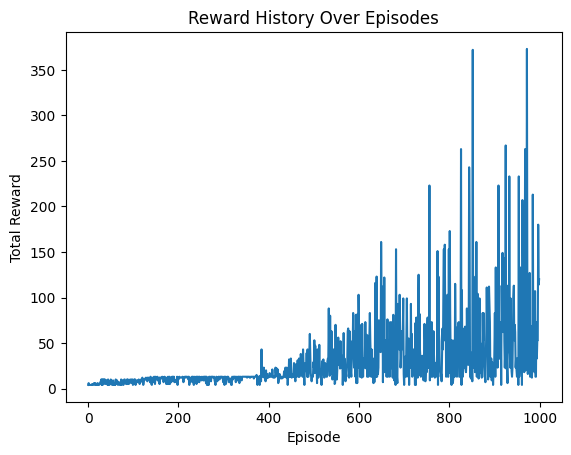

In [39]:
# Plot the reward history
plt.plot(episode_rewards)
plt.title('Reward History Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

In [40]:
test_sarsa_lambda_agent(trained_agent)

Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 1061.61it/s]

Total reward across all episodes:  5061
Average Reward over 100 episodes: 50.61


50.61

In [41]:
with open('../agents/sarsa-agent.pkl', 'wb') as f:
    pickle.dump(trained_agent, f)